# Model Evaluation
This notebook contains steps for evaluating models to predict the percentage increase in Queens.  
The step I'll take it as below ...
1. Compare the total RMSE (sum of all 5 zipcodes) based on rolling forecast between models
2. Using the best model, forecast for the future terms
3. Find the zipcode with the most increase

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns

import pickle

from SCRIPT.eval_tools import *

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
with open('PKL/timeseries_queens_p.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [4]:
df.index = pd.DatetimeIndex(df.index.values, freq='infer')

In [5]:
df.columns = df.columns.astype(str)

In [6]:
trdf = df.iloc[:int(len(df)*.8)]
#tedf = df.iloc[int(len(df)*.8):]

For the initial univariate modeling, I will compare the top 5 zipcodes with the highest deviation from the average and one zipcode closest to the average.

In [7]:
select_zipcode = ['11101', '11693', '11692', '11694', '11103']

I'll run each model for each of the zipcodes. Then take the sum of squares across all predictions of all 5 zipcodes to compare between models.

## Data
Let's just see what's the general range of our data.

In [8]:
trdf.describe().T.describe()[['mean', 'min', 'max']]

,mean,min,max
count,54.000000,54.000000,54.000000
mean,0.304256,-1.846482,2.089068
std,0.092616,0.324990,0.267506
min,0.189724,-2.759326,1.726985
25%,0.233998,-2.000986,1.938627
50%,0.280368,-1.886139,2.030825
75%,0.365218,-1.620267,2.160067
max,0.666888,-1.285888,3.124273


Average percent increase is about 0.3%. The average value ranges from -1.85% to 2.09%. Overall the minimum value is -2.76 and the maximum value is 3.12.

In [9]:
# dividing up dataframe
zip_1 = select_zipcode[0]
sel_df1 = df[zip_1]
zip_2 = select_zipcode[1]
sel_df2 = df[zip_2]
zip_3 = select_zipcode[2]
sel_df3 = df[zip_3]
zip_4 = select_zipcode[3]
sel_df4 = df[zip_4]
zip_5 = select_zipcode[4]
sel_df5 = df[zip_5]

# 0. Baseline model
Let's first see how it performs with baseline model. Here we will use the persistence algorithm, which predicts the value to be the same as the last observed value.

In [10]:
baseline_RMSE = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    pred = df.shift()[-40:]
    y_test = df[-40:]
    baseline_RMSE.append(RMSE(y_test, pred))

In [11]:
results = pd.DataFrame(baseline_RMSE, columns = ['baseline'])

# 1. SARIMA 
Our model has a seasonality and controllable stationarity. 

### zipcode [1]
---

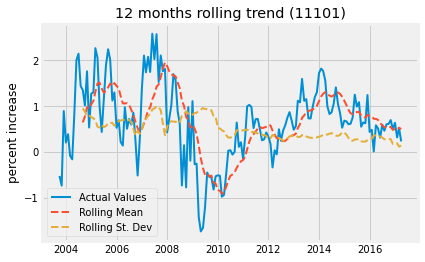

In [12]:
plot_moving_avg(sel_df1[:-40], 12, zip_1)

In [13]:
run_dickyey_fuller(sel_df1[:-40], zip_1)

Null Rejected (p = 0.0375). 11101 time series is stationary


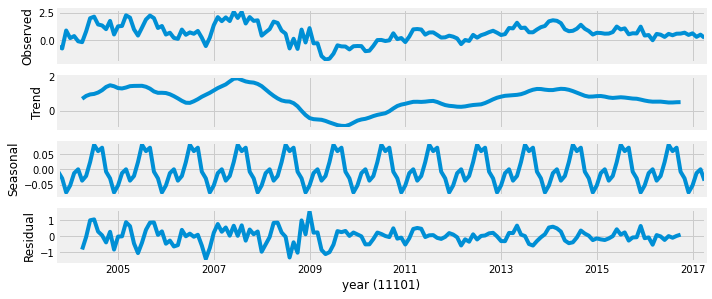

In [14]:
plot_decomposition(sel_df1[:-40], zip_1)

Time series is stationary but shows seasonality.

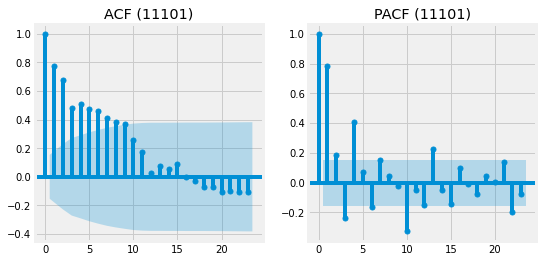

In [15]:
def_acf_pacf(sel_df1[:-40], zip_1)

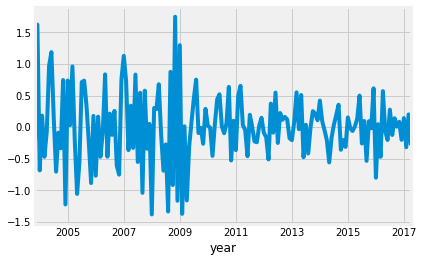

In [16]:
plot_basic(sel_df1[:-40].diff(1)[1:])

In [17]:
run_dickyey_fuller(sel_df1[:-40].diff(1)[1:], zip_1)

Null Rejected (p = 0.0041). 11101 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [18]:
pdq, SPDQ = find_sarima_param(sel_df1[:-40])

pdq: (1, 1, 1), PDQS: (0, 0, 1, 12) - AIC: 131.0


In [19]:
sarima = SARIMAX(sel_df1[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model1 = sarima.fit()
print(sarima_model1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11101   No. Observations:                  163
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 -61.502
Date:                            Wed, 07 Oct 2020   AIC                            131.003
Time:                                    22:06:07   BIC                            142.992
Sample:                                10-01-2003   HQIC                           135.874
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8314      0.066    -12.641      0.000      -0.960      -0.703
ma.L1          1.6271      0.257   

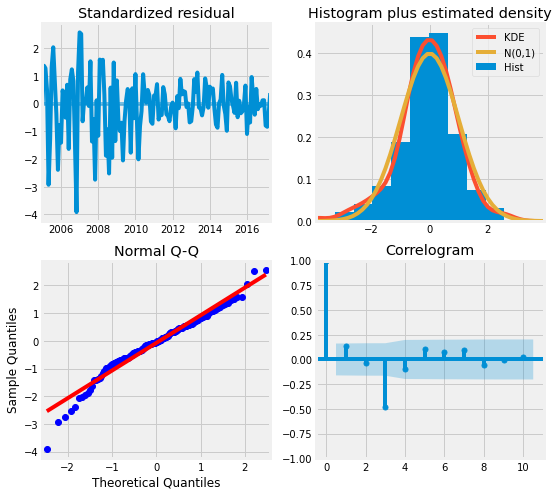

In [20]:
sarima_model1.plot_diagnostics(figsize = (8, 8))
plt.show()

For testing, we will calculate rmse based on rolling forecast.

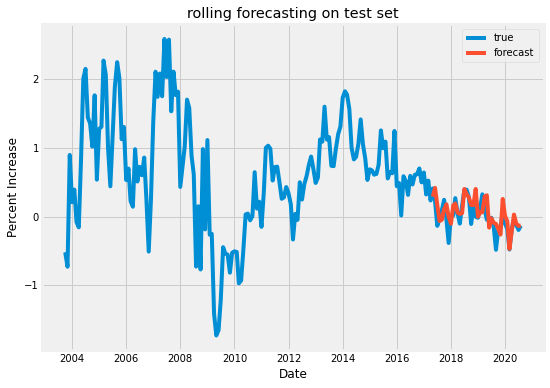

In [21]:
rmse_1 = test_RMSE(sel_df1, pdq, SPDQ)

### zipcode [2]
---

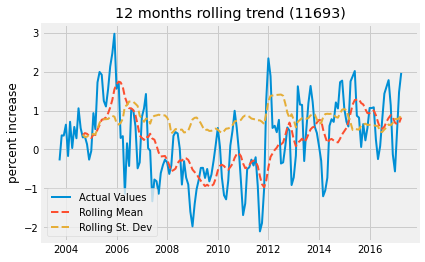

In [22]:
plot_moving_avg(sel_df2[:-40], 12, zip_2)

In [23]:
run_dickyey_fuller(sel_df2[:-40], zip_2)

Failed to reject the null (p = 0.4819). 11693 time series is not stationary


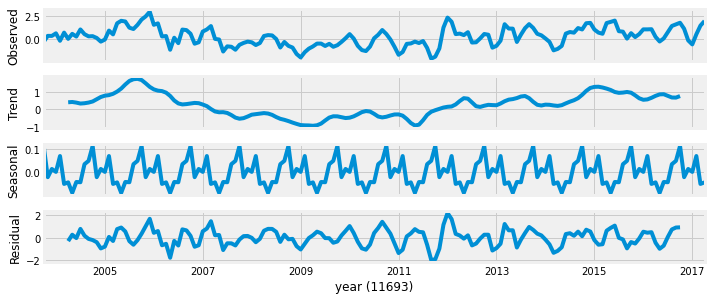

In [24]:
plot_decomposition(sel_df2[:-40], zip_2)

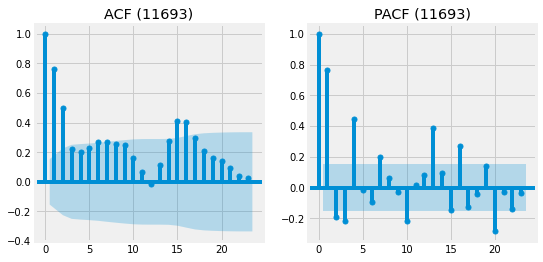

In [25]:
def_acf_pacf(sel_df2[:-40], zip_2)

Removing trend by differencing

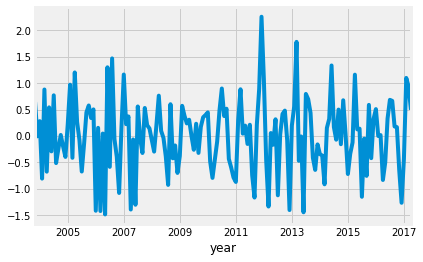

In [26]:
plot_basic(sel_df2[:-40].diff(1)[1:])

In [27]:
run_dickyey_fuller(sel_df2[:-40].diff(1)[1:], zip_2)

Null Rejected (p = 0.0). 11693 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [28]:
pdq, SPDQ = find_sarima_param(sel_df2[:-40])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq: (1, 1, 1), PDQS: (1, 0, 1, 12) - AIC: 225.82


In [29]:
sarima = SARIMAX(sel_df2[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model2 = sarima.fit()
print(sarima_model2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11693   No. Observations:                  163
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -107.910
Date:                            Wed, 07 Oct 2020   AIC                            225.820
Time:                                    22:06:27   BIC                            240.806
Sample:                                10-01-2003   HQIC                           231.908
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9288      0.033    -27.975      0.000      -0.994      -0.864
ma.L1          1.1434      0.082   

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


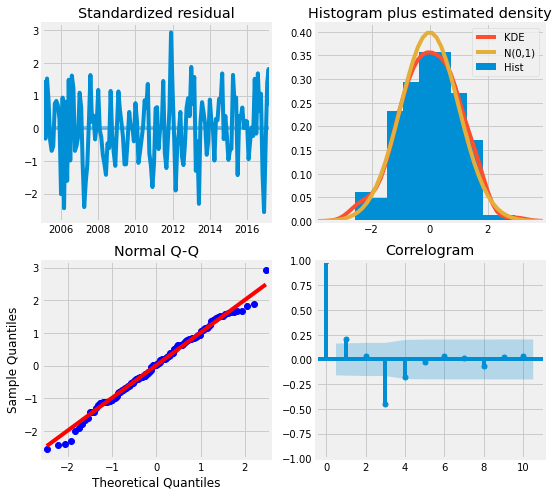

In [30]:
sarima_model2.plot_diagnostics(figsize = (8, 8))
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

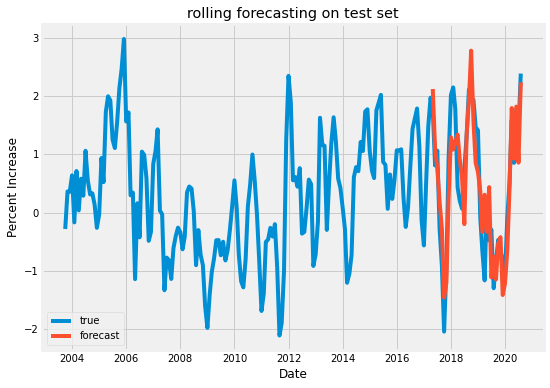

In [31]:
rmse_2 = test_RMSE(sel_df2, pdq, SPDQ)

### zipcode [3]
---

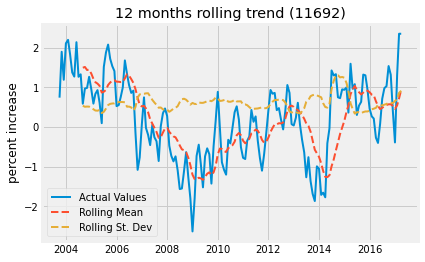

In [32]:
plot_moving_avg(sel_df3[:-40], 12, zip_3)

In [33]:
run_dickyey_fuller(sel_df3[:-40], zip_3)

Failed to reject the null (p = 0.2375). 11692 time series is not stationary


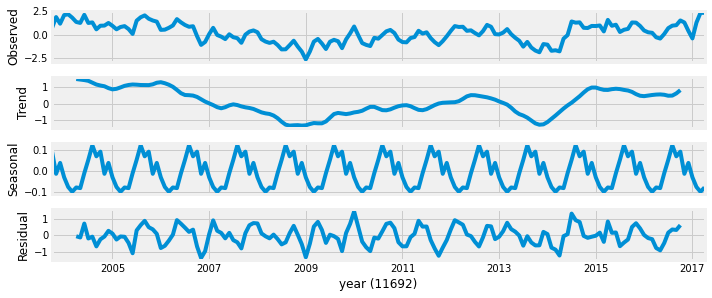

In [34]:
plot_decomposition(sel_df3[:-40], zip_3)

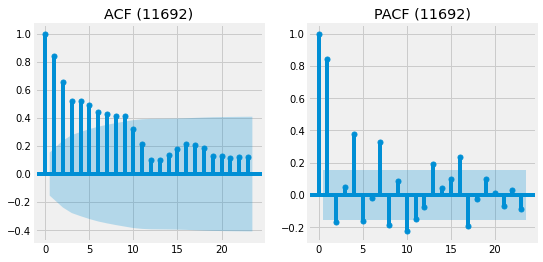

In [35]:
def_acf_pacf(sel_df3[:-40], zip_3)

Removing trend by differencing

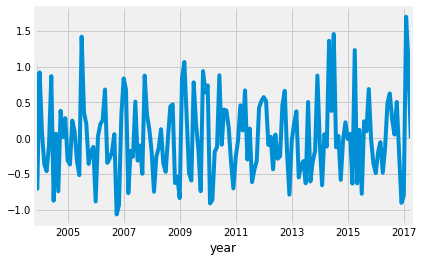

In [36]:
plot_basic(sel_df3[:-40].diff(1)[1:])

In [37]:
run_dickyey_fuller(sel_df3[:-40].diff(1)[1:], zip_3)

Null Rejected (p = 0.0). 11692 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [38]:
pdq, SPDQ = find_sarima_param(sel_df3[:-40])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq: (1, 0, 1), PDQS: (1, 0, 1, 12) - AIC: 175.32


In [39]:
sarima = SARIMAX(sel_df3[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model3 = sarima.fit()
print(sarima_model3.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11692   No. Observations:                  163
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -82.660
Date:                            Wed, 07 Oct 2020   AIC                            175.321
Time:                                    22:06:53   BIC                            190.340
Sample:                                10-01-2003   HQIC                           181.423
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9343      0.034     27.300      0.000       0.867       1.001
ma.L1          0.1279      0.075   

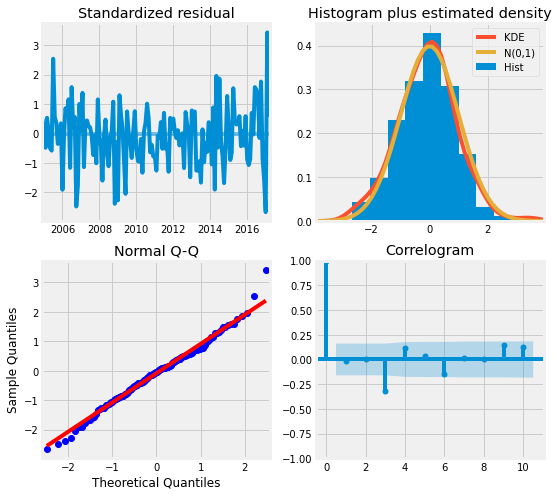

In [40]:
sarima_model3.plot_diagnostics(figsize = (8, 8))
plt.show()

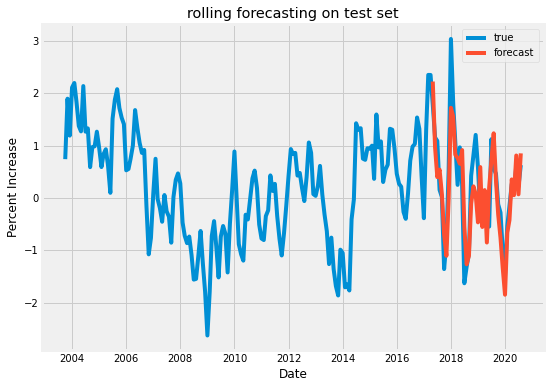

In [41]:
rmse_3= test_RMSE(sel_df3, pdq, SPDQ)

### zipcode [4]
---

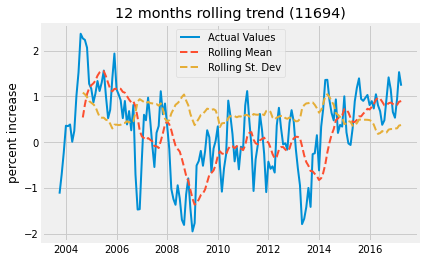

In [42]:
plot_moving_avg(sel_df4[:-40], 12, zip_4)

In [43]:
run_dickyey_fuller(sel_df4[:-40], zip_4)

Failed to reject the null (p = 0.5424). 11694 time series is not stationary


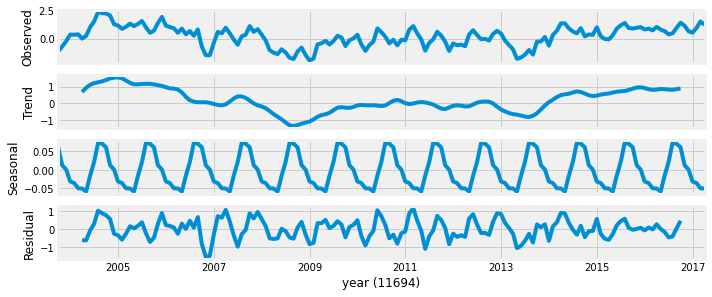

In [44]:
plot_decomposition(sel_df4[:-40], zip_4)

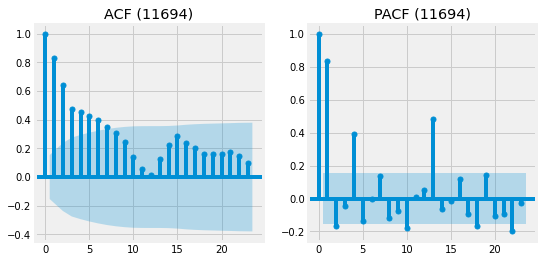

In [45]:
def_acf_pacf(sel_df4[:-40], zip_4)

Removing trend by differencing

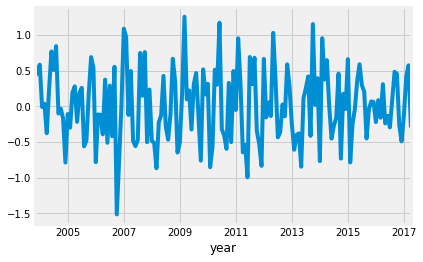

In [46]:
plot_basic(sel_df4[:-40].diff(1)[1:])

In [47]:
run_dickyey_fuller(sel_df4[:-40].diff(1)[1:], zip_4)

Null Rejected (p = 0.0). 11694 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [48]:
pdq, SPDQ = find_sarima_param(sel_df4[:-40])

pdq: (1, 0, 0), PDQS: (1, 0, 1, 12) - AIC: 118.55


In [49]:
sarima = SARIMAX(sel_df4[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model4 = sarima.fit()
print(sarima_model4.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11694   No. Observations:                  163
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood                 -55.274
Date:                            Wed, 07 Oct 2020   AIC                            118.548
Time:                                    22:07:14   BIC                            130.590
Sample:                                10-01-2003   HQIC                           123.440
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9471      0.025     38.184      0.000       0.899       0.996
ar.S.L12      -0.2349      0.106   

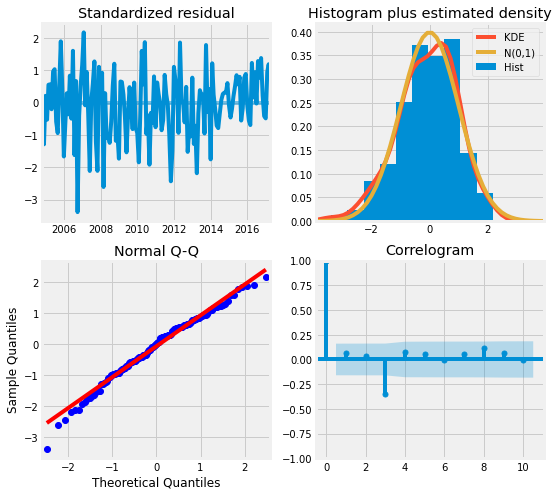

In [50]:
sarima_model4.plot_diagnostics(figsize = (8, 8))
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


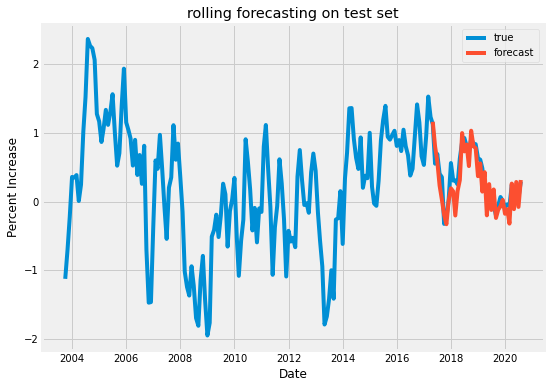

In [51]:
rmse_4 = test_RMSE(sel_df4, pdq, SPDQ)

### zipcode [5]
---

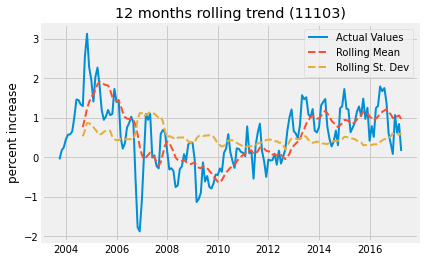

In [52]:
plot_moving_avg(sel_df5[:-40], 12, zip_5)

In [53]:
run_dickyey_fuller(sel_df5[:-40], zip_5)

Failed to reject the null (p = 0.1297). 11103 time series is not stationary


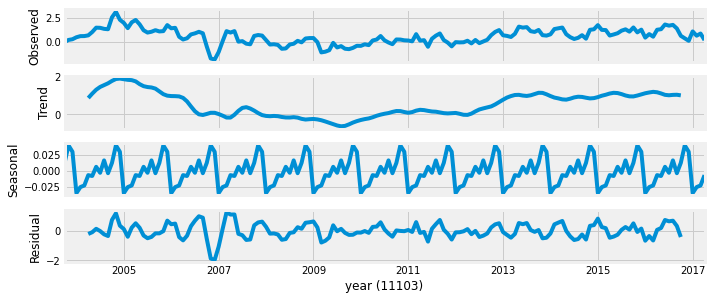

In [54]:
plot_decomposition(sel_df5[:-40], zip_5)

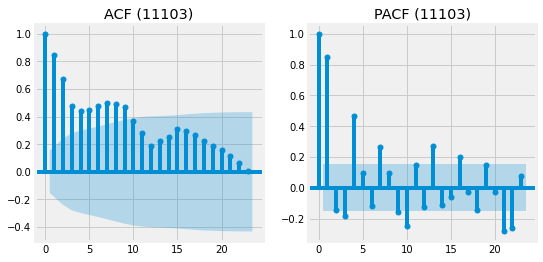

In [55]:
def_acf_pacf(sel_df5[:-40], zip_5)

Removing trend by differencing

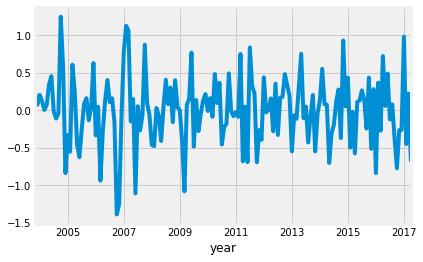

In [56]:
plot_basic(sel_df5[:-40].diff(1)[1:])

In [57]:
run_dickyey_fuller(sel_df5[:-40].diff(1)[1:], zip_5)

Null Rejected (p = 0.0001). 11103 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [58]:
pdq, SPDQ = find_sarima_param(sel_df5[:-40])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq: (0, 1, 1), PDQS: (1, 0, 1, 12) - AIC: 95.94


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [59]:
sarima = SARIMAX(sel_df5[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model5 = sarima.fit()
print(sarima_model5.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11103   No. Observations:                  163
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -43.968
Date:                            Wed, 07 Oct 2020   AIC                             95.935
Time:                                    22:07:32   BIC                            107.924
Sample:                                10-01-2003   HQIC                           100.807
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1083      0.073      1.478      0.139      -0.035       0.252
ar.S.L12      -0.2100      0.072   

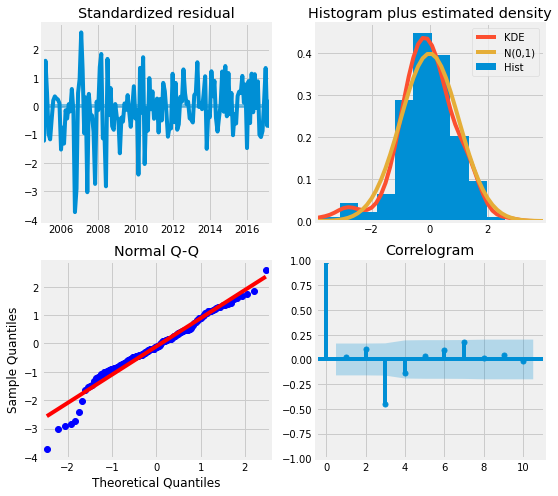

In [60]:
sarima_model5.plot_diagnostics(figsize = (8, 8))
plt.show()

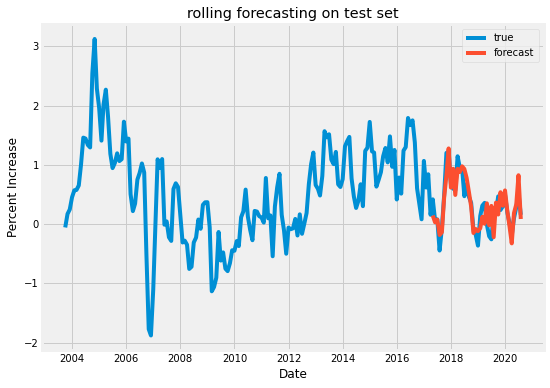

In [61]:
rmse_5 = test_RMSE(sel_df5, pdq, SPDQ)

## SARIMA Total RMSE

In [62]:
results['SARIMA'] = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5]

# Facebook Prophet
Now I will run the similar step using Facebook Prophet.

In [63]:
sel_df1 = sel_df1.reset_index()

In [64]:
fbp_rmse_1, forecast, model = fb_prophet_forecast(sel_df1)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


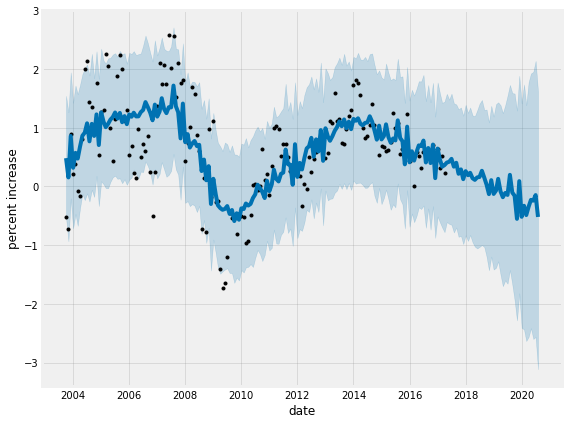

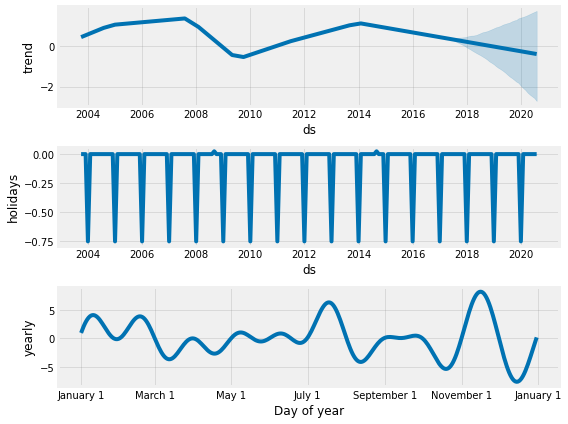

In [65]:
fbp_plot(forecast, model)

In [66]:
sel_df2 = sel_df2.reset_index()

In [67]:
fbp_rmse_2, forecast, model = fb_prophet_forecast(sel_df2)

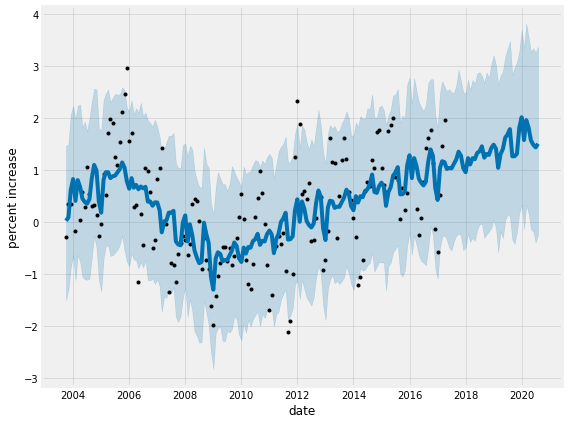

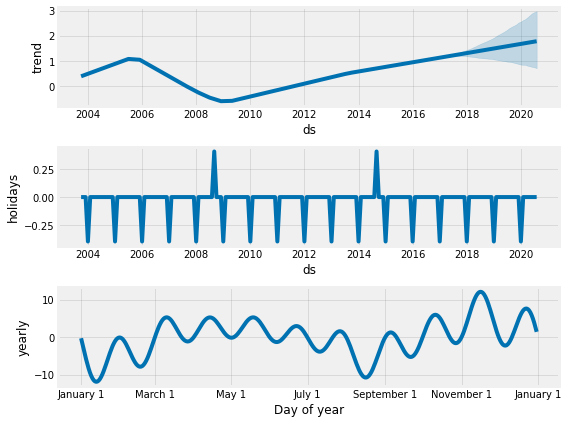

In [68]:
fbp_plot(forecast, model)

In [69]:
sel_df3 = sel_df3.reset_index()

In [70]:
fbp_rmse_3, forecast, model = fb_prophet_forecast(sel_df3)

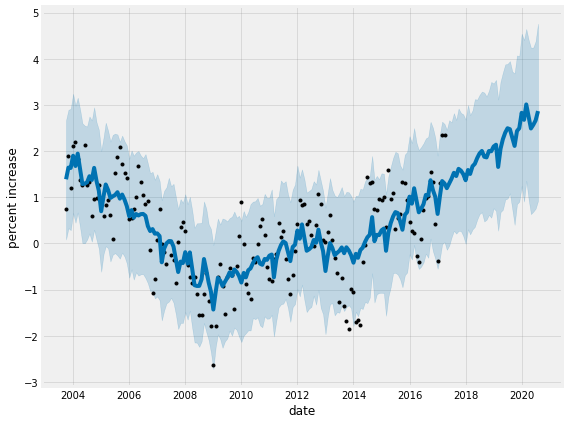

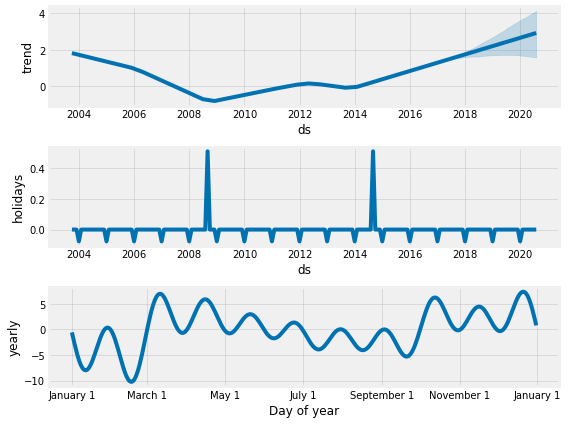

In [71]:
fbp_plot(forecast, model)

In [72]:
sel_df4 = sel_df4.reset_index()

In [73]:
fbp_rmse_4, forecast, model = fb_prophet_forecast(sel_df4)

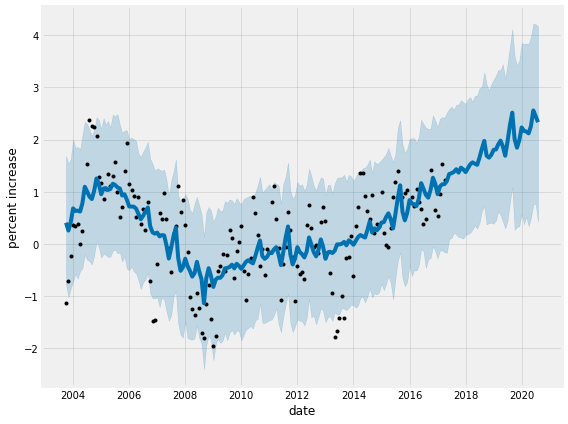

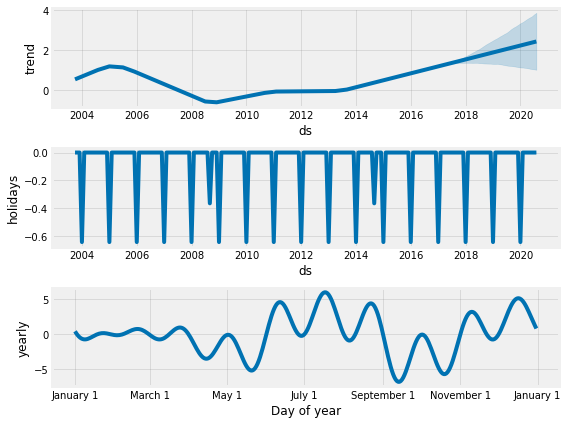

In [74]:
fbp_plot(forecast, model)

In [75]:
sel_df5 = sel_df5.reset_index()

In [76]:
fbp_rmse_5, forecast, model = fb_prophet_forecast(sel_df5)

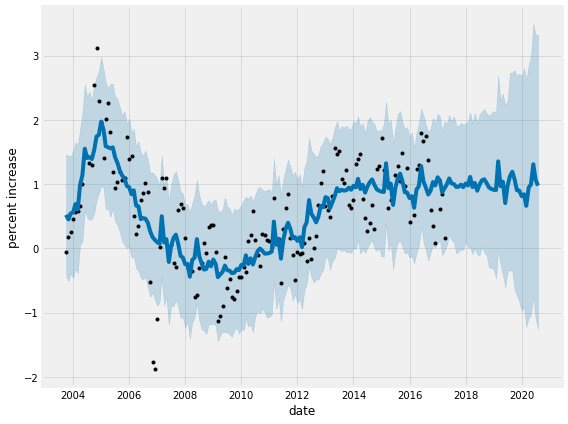

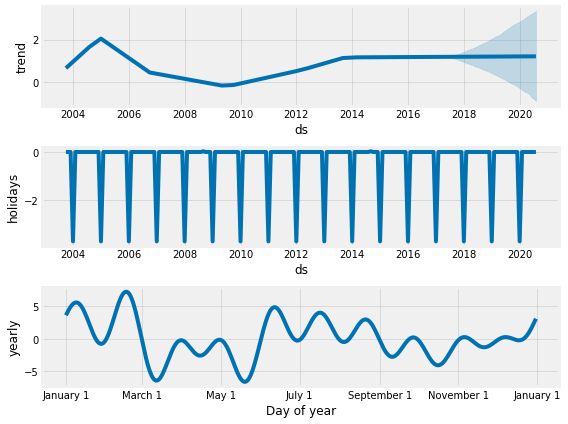

In [77]:
fbp_plot(forecast, model)

## FB Prophet total RMSE

In [78]:
results['FB_Prophet'] = [fbp_rmse_1, fbp_rmse_2, fbp_rmse_3, fbp_rmse_4, fbp_rmse_5]

In [81]:
results.sum()

baseline      2.406434
SARIMA        1.720418
FB_Prophet    6.411532
dtype: float64

It seems like generally SARIMA is performing better. Let's try the deep learning method now.

# LSTM
I'll use LSTM to do sequence prediction. How it works is that we break each time stamp with input of all observation to that point and output of the following sequence and feed into the LSTM architecture which predicts for the immediately following number. I'll set up a few functions to run them, which will be imported here just like what I did above.

In [290]:
from SCRIPT.lstm_tools import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [291]:
steps = 3

### Zipcode 1

In [ ]:
sel_df1 = sel_df1.set_index('index')

In [420]:
# train/test split
trdf1 = sel_df1[:-40]
tedf1 = sel_df1[-(40+steps):]

In [421]:
inputs, outputs = sequence_generator(trdf1.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf1.iloc[:, 0], steps = steps)

In [422]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

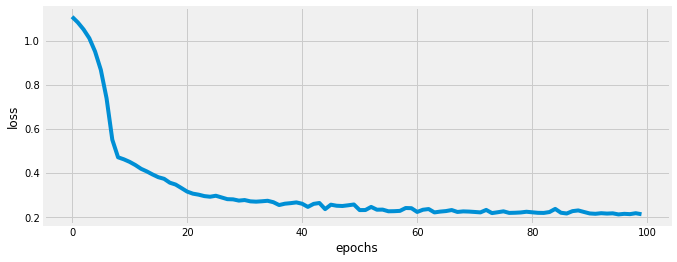

In [423]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

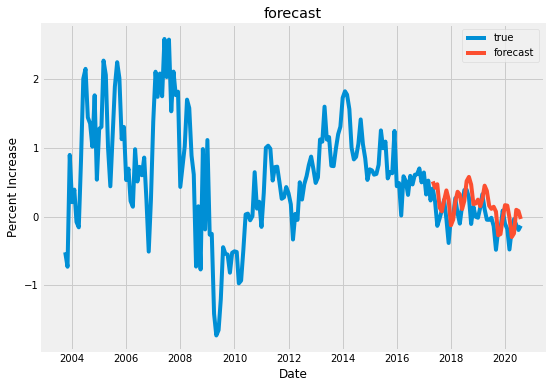

In [424]:
pred = model.predict(test_inputs)
rmse1 = show_RMSE(sel_df1, test_outputs, pred)

### Zipcode 2

In [282]:
sel_df2 = sel_df2.set_index('index')

In [425]:
# train/test split
trdf2 = sel_df2[:-40]
tedf2 = sel_df2[-(40+steps):]

In [426]:
inputs, outputs = sequence_generator(trdf2.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf2.iloc[:, 0], steps = steps)

In [427]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))

model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

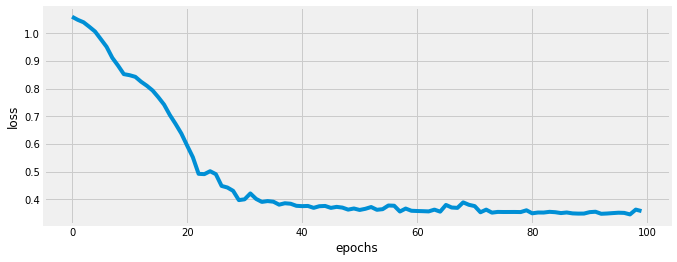

In [428]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

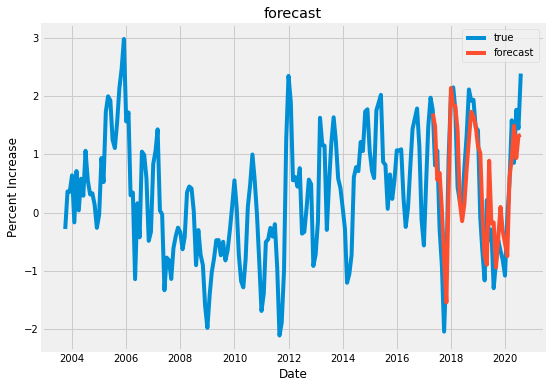

In [429]:
pred = model.predict(test_inputs)
rmse2 = show_RMSE(sel_df2, test_outputs, pred)

### Zipcode 3

In [302]:
sel_df3 = sel_df3.set_index('index')

In [430]:
# train/test split
trdf3 = sel_df3[:-40]
tedf3 = sel_df3[-(40+steps):]

In [431]:
inputs, outputs = sequence_generator(trdf3.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf3.iloc[:, 0], steps = steps)

In [432]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))

model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

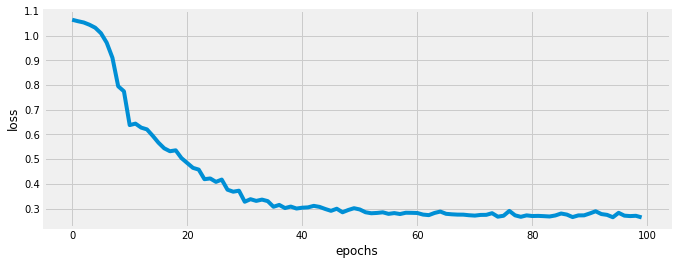

In [433]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

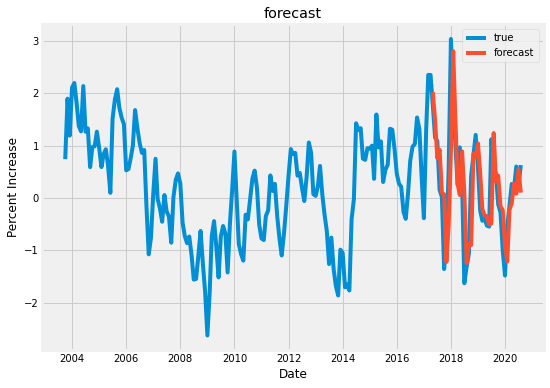

In [434]:
pred = model.predict(test_inputs)
rmse3 = show_RMSE(sel_df3, test_outputs, pred)

### Zipcode 4

In [311]:
sel_df4 = sel_df4.set_index('index')

In [435]:
# train/test split
trdf4 = sel_df4[:-40]
tedf4 = sel_df4[-(40+steps):]

In [436]:
inputs, outputs = sequence_generator(trdf4.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf4.iloc[:, 0], steps = steps)

In [437]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))

model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

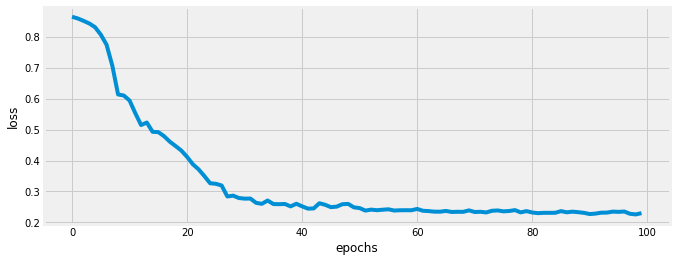

In [438]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

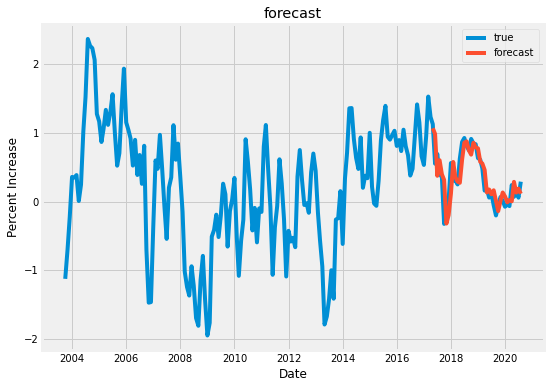

In [439]:
pred = model.predict(test_inputs)
rmse4 = show_RMSE(sel_df4, test_outputs, pred)

### Zipcode 5

In [317]:
sel_df5 = sel_df5.set_index('index')

In [447]:
# train/test split
trdf5 = sel_df5[:-40]
tedf5 = sel_df5[-(40+steps):]

In [448]:
inputs, outputs = sequence_generator(trdf5.iloc[:, 0], steps = steps)
test_inputs, test_outputs = sequence_generator(tedf5.iloc[:, 0], steps = steps)

In [459]:
# LSTM architecture
model = Sequential()
model.add(LSTM(64, activation='relu', 
               input_shape=(steps, 1),
              return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu',return_sequences = True))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
history = model.fit(inputs, outputs, epochs = 100, verbose = 0)

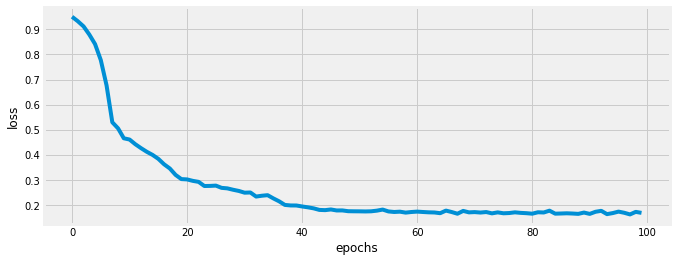

In [460]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

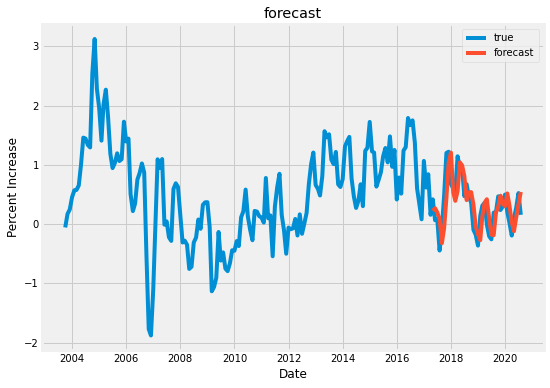

In [461]:
pred = model.predict(test_inputs)
rmse5 = show_RMSE(sel_df5, test_outputs, pred)

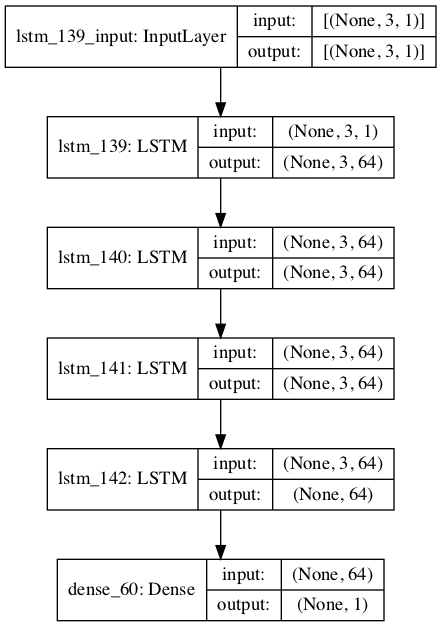

In [470]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="lstm_arch.png", 
           show_shapes=True)

### Total LSTM


In [462]:
results['LSTM'] = [rmse1, rmse2, rmse3, rmse4, rmse5]

In [463]:
results.sum()

baseline      2.406434
SARIMA        1.720418
FB_Prophet    6.411532
LSTM          2.221384
dtype: float64

SARIMA still tops the performance.

In [419]:
results

,baseline,SARIMA,FB_Prophet,LSTM
0,0.209293,0.169575,0.241550,0.279246
1,0.800809,0.589143,1.550317,0.675985
2,0.853276,0.538262,2.226738,0.785413
3,0.227831,0.201345,1.602403,0.230954
4,0.315225,0.222093,0.790525,0.302695
